# Genesis Analysis

We have previously extracted the markers from the phantom images and saved them as json files in the `_segmentation_data` notebook. These were mostly relatively straightforward to segment. We were unable to extract the markers from the CT of the phillips phantom, so Paul created an 'artificial' ground truth based on the powerpoint slides in this repo.

# "Mr Goam" analysis (Sydney phantom)

In [1]:
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume, MatchedMarkerVolumes
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist
import numpy as np

# create marker volumes:
mr_volume_with_DC = MarkerVolume(r'..\_segmentation_data\GOAM_MRI\2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00002\slicer_centroids.mrk.json')
mr_volume_no_DC = MarkerVolume(r'..\_segmentation_data\GOAM_MRI\2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00001\slicer_centroids.mrk.json')
ct_volume = MarkerVolume(r'..\_segmentation_data\GOAM_CT\slicer_centroids.mrk.json')

# match markers:
no_DC_match = MatchedMarkerVolumes(ct_volume, mr_volume_no_DC, n_refernce_markers=7)
with_DC_match = MatchedMarkerVolumes(ct_volume, mr_volume_with_DC, n_refernce_markers=7)

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at ..\_segmentation_data\GOAM_CT. Continuing


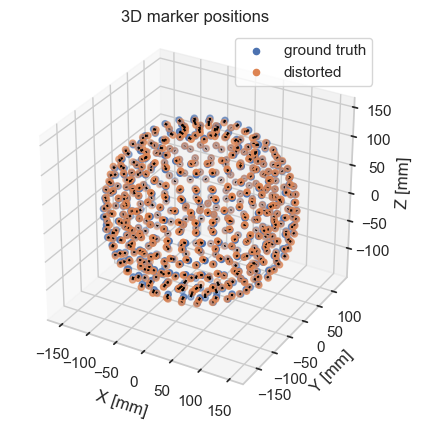

In [2]:
no_DC_match.plot_3D_markers()

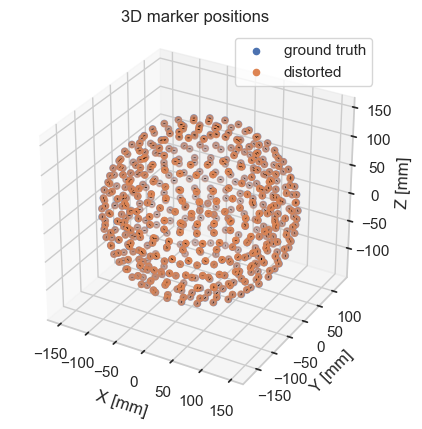

In [3]:
with_DC_match.plot_3D_markers()

In general, you can see that the Philipps distortion correction is excellent. Even with no distortion correction, the distortion in this FOV is quite small. We can get a bit more quantititative about this:

In [4]:
np.median(with_DC_match.MatchedCentroids.match_distance)

0.5951564026103748

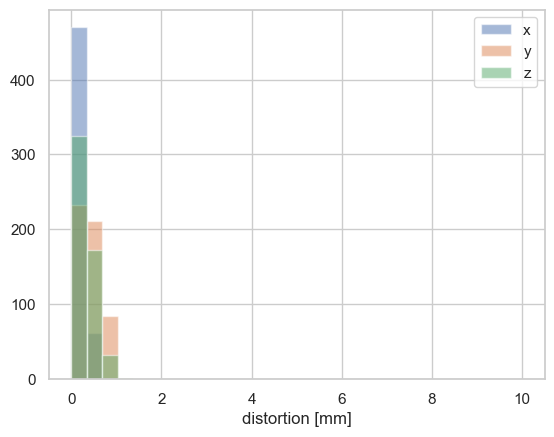

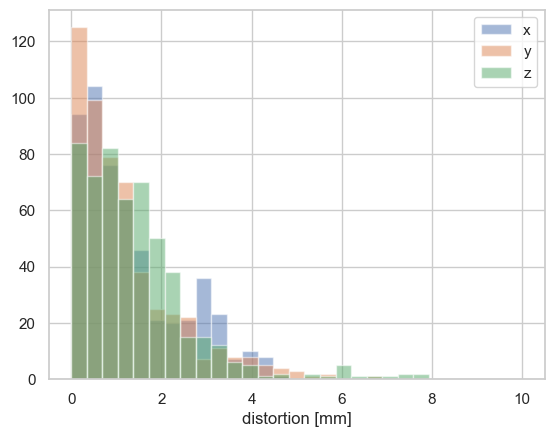

In [5]:
plot_distortion_xyz_hist(with_DC_match)
plot_distortion_xyz_hist(no_DC_match)

# Mr Goam spherical harmonics

Based on these (distorted) marker positions, we can calculate the gradient fields, and characterise these in terms of spherical harmonics. For this to really be interesting, we would need a phantom covering a bigger FOV, but nevertheless:

In [6]:
from mri_distortion_toolkit.FieldCalculation import ConvertMatchedMarkersToBz
from mri_distortion_toolkit import calculate_harmonics

Bz_field = ConvertMatchedMarkersToBz(no_DC_match.MatchedCentroids, mr_volume_no_DC.dicom_data)
gradient_strength = np.array(mr_volume_no_DC.dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(Bz_field.MagneticFields,
                                                                                n_order=8,
                                                                                norm=normalisation_factor)

Initial pk-pk:        4.250e+06 μT
Reconstructed pk-pk:  4.252e+06 μT
Residual pk-pk:       6.997e+03 μT ( 0.2%)
Initial pk-pk:        4.196e+06 μT
Reconstructed pk-pk:  4.196e+06 μT
Residual pk-pk:       9.733e+03 μT ( 0.2%)
Initial pk-pk:        3.113e+06 μT
Reconstructed pk-pk:  3.111e+06 μT
Residual pk-pk:       3.860e+03 μT ( 0.1%)


The output above indicates:

1. we scaled the harmonics - I scale them to a strength of 1 mT/m so we can easily use them for different sequences
2. The initial peak to peak perturbation in the input fields, the reconstructed peak-peak, and the peak-peak of the residual (initial - reconsttructed) field. Note that the residual is <1% in all cases, indicating a good fit.

Now we have these harmonics, we can make some nice plots and print the dominant harmonics:

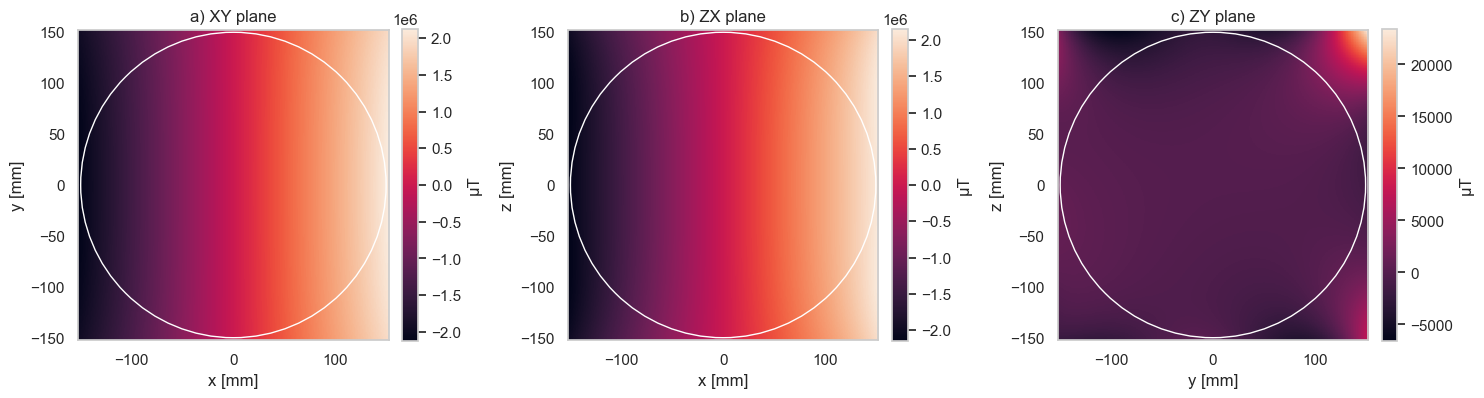

In [7]:
G_x_Harmonics.plot_cut_planes()

Note that this varies in X as expected; in the ZY plane the field is close to 0. These plots are pretty but not actually all that informative. For me a more interesting metric is the dominant harmonics:

In [8]:
G_x_Harmonics.print_key_harmonics()


Only displaying values >=  1% of the peak harmonic.
Values are in pk=pk [μT]
A_1_1   -4.1598e+06f
A_3_1    1.1328e+05f
A_3_3   -6.3729e+04f
A_5_1    9.3628e+04f


You'd have to be a real nerd to know it, but the dominant harmonic for the X gradient should be A_1_1, which it is. Furthermore, through arguments about symetry (again you'd have to be a real nerd) I'd expect the other dominant harmonics to be A_3_1, A_5_1, and maybe A_7_1. This is also what we see; in addition we have a reasonable contriubtion from the A_3_3 term.

If we'd been able to apply the reverse gradient technique, we'd also be able to pull out an estimate of the B0 field, which is probably more interesting than the harmonics - at the moment the conclusion is basically "the gradient fields look like gradient fields, what a surprise!"

## Distortion Correction

Just for fun, let's run our distortion correction algorithm over the distorted data and see how we do. This code will use the harmonics to reconstruct the fields, and from the fields reconstruct a corrected image. We have two correction algorithms; I'm going to use the image domain because it's faster and in most cases just as good.

> **so far we have only been using data in this repository; to run the next piece of code you have to download the actual images and update the distorted_data_loc variable**
> **In addition, phillips MRI seems to contain some weird file that isn't image data - this causes errors in our code which i presently 'solved' by deleting the offending file**

In [9]:
from pathlib import Path
from mri_distortion_toolkit.DistortionCorrection import ImageDomainDistortionCorrector

dis_data_loc = Path(r'C:\Users\Brendan\Downloads\GOAM-01092022_Genesis\GOAM\GOAM_MRI\2022-08__Studies\GOAM^ImageX_ZZZIMAGEX_MR_2022-08-31_172341_._T2.3D.Tra.2min_n301__00001')

GDC = ImageDomainDistortionCorrector(ImageDirectory=dis_data_loc.resolve(),
                                gradient_harmonics=[G_x_Harmonics.harmonics,
                                                    G_y_Harmonics.harmonics,
                                                    G_z_Harmonics.harmonics],
                                dicom_data=mr_volume_no_DC.dicom_data,
                                correct_through_plane=True)

GDC.correct_all_images()
GDC.save_all_images()  # saves as png so you can quickly inspect results
GDC.save_all_images_as_dicom()  # saves as dicom which can be read into analysis packages.

 |----------------------------------------------------------------------------------------------------| 0.0% 
 |█---------------------------------------------------------------------------------------------------| 1.3% 
 |██--------------------------------------------------------------------------------------------------| 2.6% 
 |███-------------------------------------------------------------------------------------------------| 3.8% 
 |█████-----------------------------------------------------------------------------------------------| 5.1% 
 |██████----------------------------------------------------------------------------------------------| 6.4% 
 |███████---------------------------------------------------------------------------------------------| 7.7% 
 |████████--------------------------------------------------------------------------------------------| 9.0% 
 |██████████------------------------------------------------------------------------------------------| 10.3% 
 |███████

 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.9% 
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.2% 
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.4% 
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% 

total time:  1144.3s
mean time per slice =  1e+00s
total correction time:  1144.3 s


[DistortionCorrection.py: line 153] 5678290 negative pixels detected; setting these to zero and continuing


images export to png
images exported to dicom


Ok, that actually took a really long time - this is much higher data resolution than we get on our scanner!
anyway, since we saved all the results as both png and dicom, let's take a look at one of the pngs:

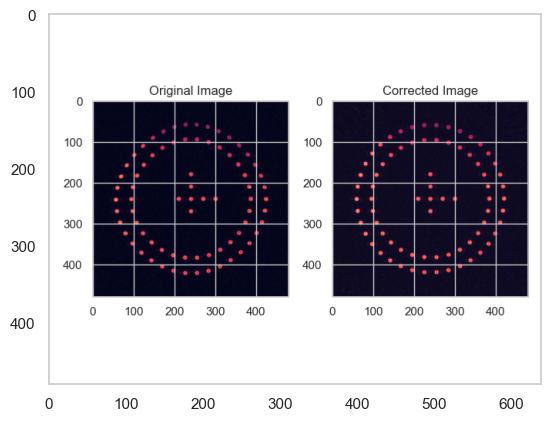

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

corrected_image_loc = dis_data_loc / 'corrected' / '154.png'
# I picked slice 154 as it is a nice central slice
img = mpimg.imread(corrected_image_loc)
plt.imshow(img)
plt.grid(False)
plt.show()


:man_shrugging: looks fine right - visually we don't see much difference.
To be more quantiative, we can read the corrected data back into a marker volume, and analyse the match distance:

[MarkerAnalysis.py: line 209  WARNING] this code has not been tested with non-siemens scanners. If dicom standards work properlythis code will too...


total segmentation time:  111.0 s


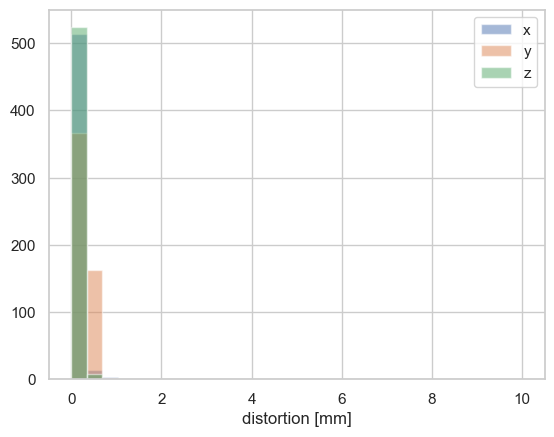

In [11]:
# corrected_volume = MarkerVolume(dis_data_loc / 'corrected_dcm')  # this takes a while
# corrected_volume.export_to_slicer()
# corrected_volume.save_dicom_data()
corrected_volume = MarkerVolume(dis_data_loc / 'corrected_dcm') # once you've done it once you can save the data for quick loading
matched_volume_corrected = MatchedMarkerVolumes(ct_volume, corrected_volume, n_refernce_markers=7)

plot_distortion_xyz_hist(matched_volume_corrected)

(note: segmenting the markers from the images is rather time consuming - about ~10 minutes in this case. This is why we tend to save the data as json once the segmentation is complete - if you are doing this from scratch you will have toc un comment the commented lines above).

Ok - our distortion correction is clearly not as good as the Phillips! actually, I was hoping for a slightly better result than this but it's still fairly good. The outliers here may be because we didn't implement proper intensity correction in this image domain algorithm yet.

what this really highlights (again) is that the phillips algorithm is very good!

we can also have a look at the matched markers:


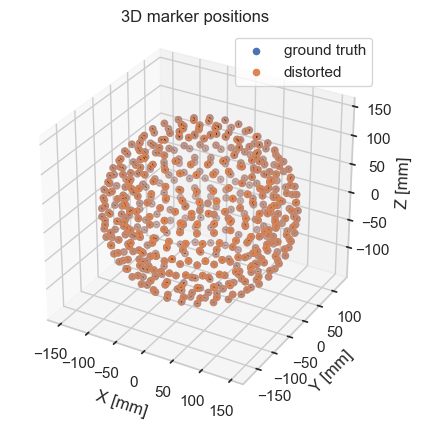

In [12]:
matched_volume_corrected.plot_3D_markers()